In [1]:
import os
import warnings
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
warnings.filterwarnings("ignore")

In [2]:
# ==== Load Raw Dataset ====
df = pd.read_excel("D:\PYTHON 3\ICTAK Python3\customer_churn_prediction/data/raw/E Commerce Dataset.xlsx", sheet_name="E Comm")

In [3]:
# ==== Replace inconsistent values ====
df["PreferredLoginDevice"] = df["PreferredLoginDevice"].replace("Phone", "Mobile Phone")
df["PreferredPaymentMode"] = df["PreferredPaymentMode"].replace("CC", "Credit Card")
df["PreferredPaymentMode"] = df["PreferredPaymentMode"].replace("COD", "Cash on Delivery")
df["PreferedOrderCat"] = df["PreferedOrderCat"].replace("Mobile", "Mobile Phone")

In [4]:
# ==== Drop identifier column ====
df = df.drop(columns=["CustomerID"])

In [5]:
# === Separate numerical and categorical columns ====
num_cols = df.select_dtypes(include=["float64", "int64"]).columns.drop("Churn")
cat_cols = df.select_dtypes(include="object").columns

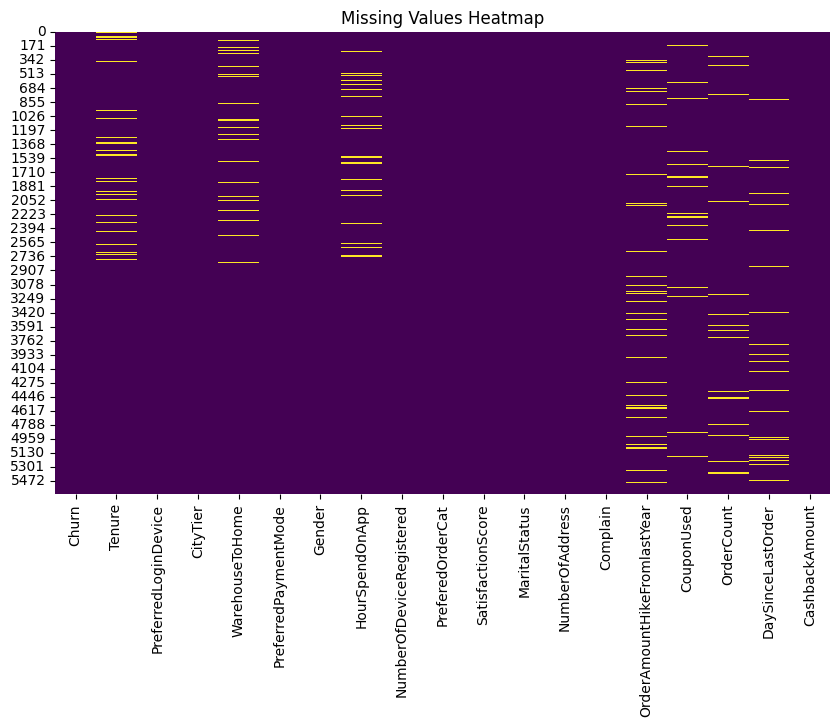

In [6]:
# === Missing Values Heatmap ===
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()


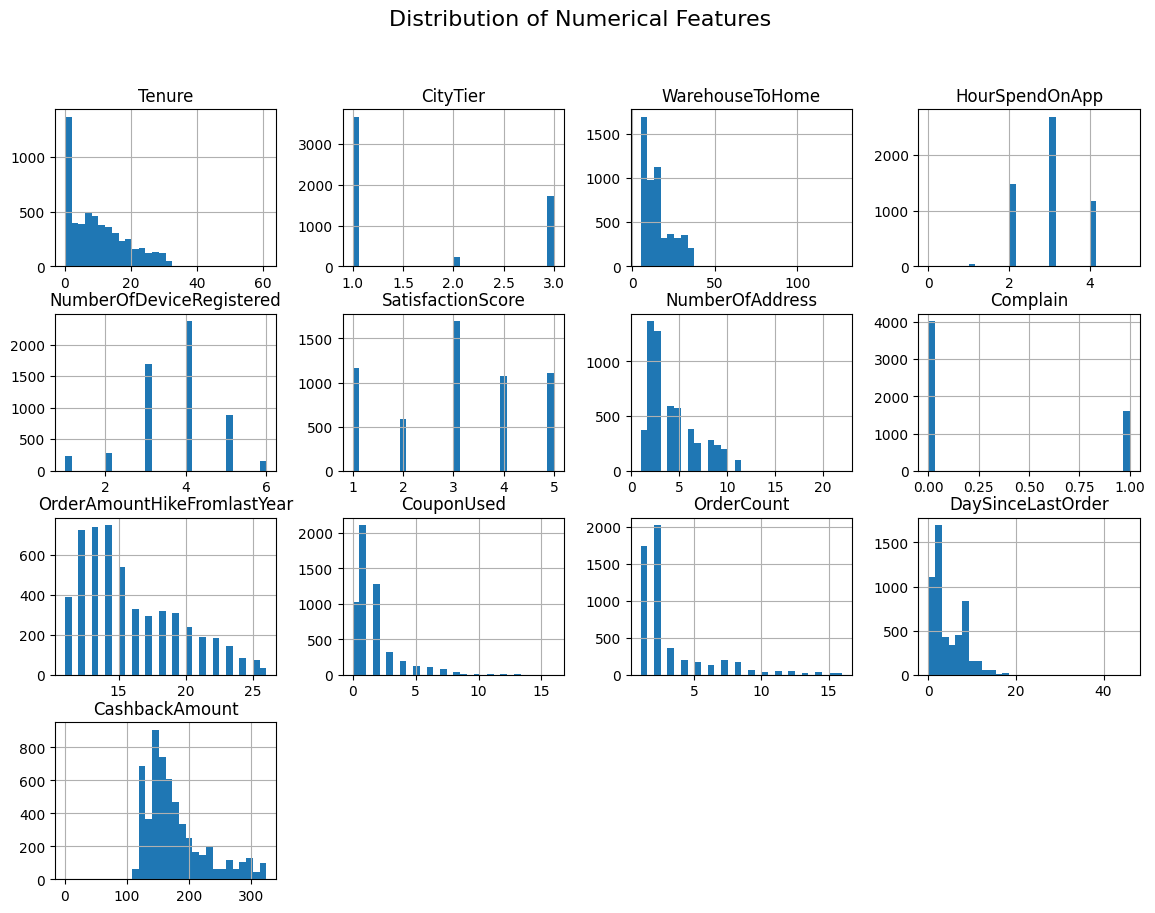

In [7]:
# === Distribution of Numerical Features ===
df[num_cols].hist(figsize=(14, 10), bins=30)
plt.suptitle("Distribution of Numerical Features", fontsize=16)
plt.show()


In [8]:
# ==== Impute missing numerical values ====
num_imputer = SimpleImputer(strategy="mean")
df[num_cols] = num_imputer.fit_transform(df[num_cols])

In [9]:
# ==== Save cleaned data before encoding ====
os.makedirs("data/cleaned", exist_ok=True)
df.to_excel("data/cleaned/E_Commerce_Cleaned_Before_Encoding.xlsx", index=False)
print("Cleaned dataset (before encoding) saved successfully.")

Cleaned dataset (before encoding) saved successfully.


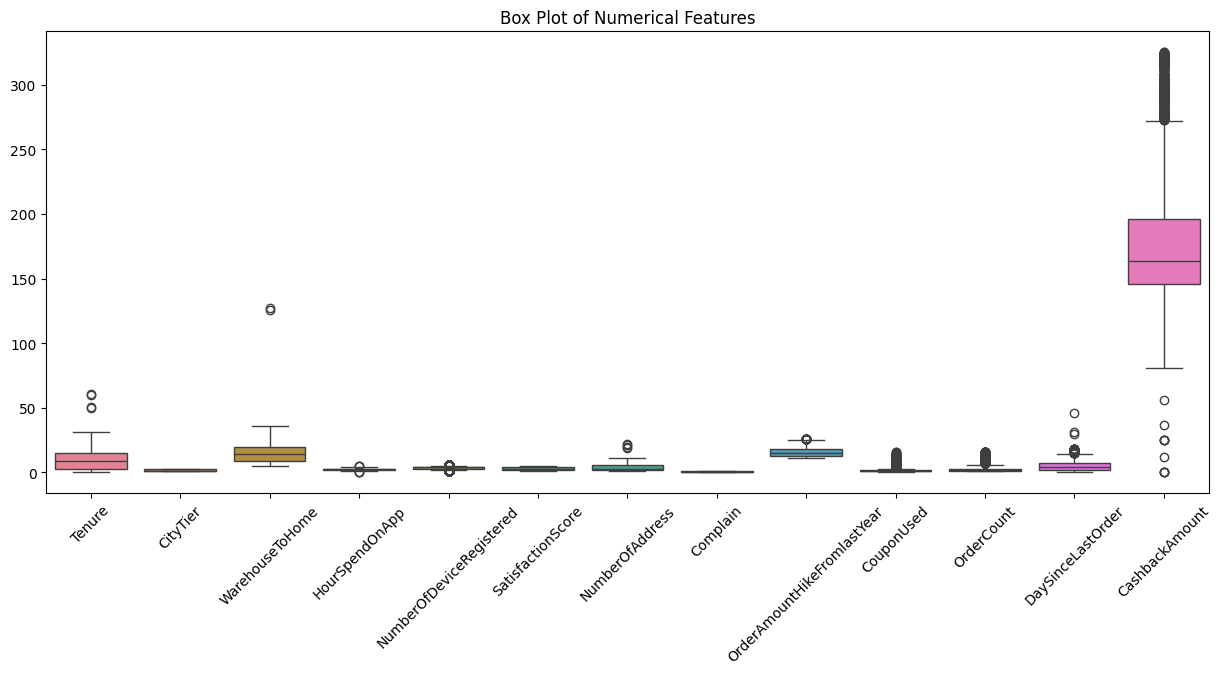

In [10]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df[num_cols])
plt.xticks(rotation=45)
plt.title("Box Plot of Numerical Features")
plt.show()


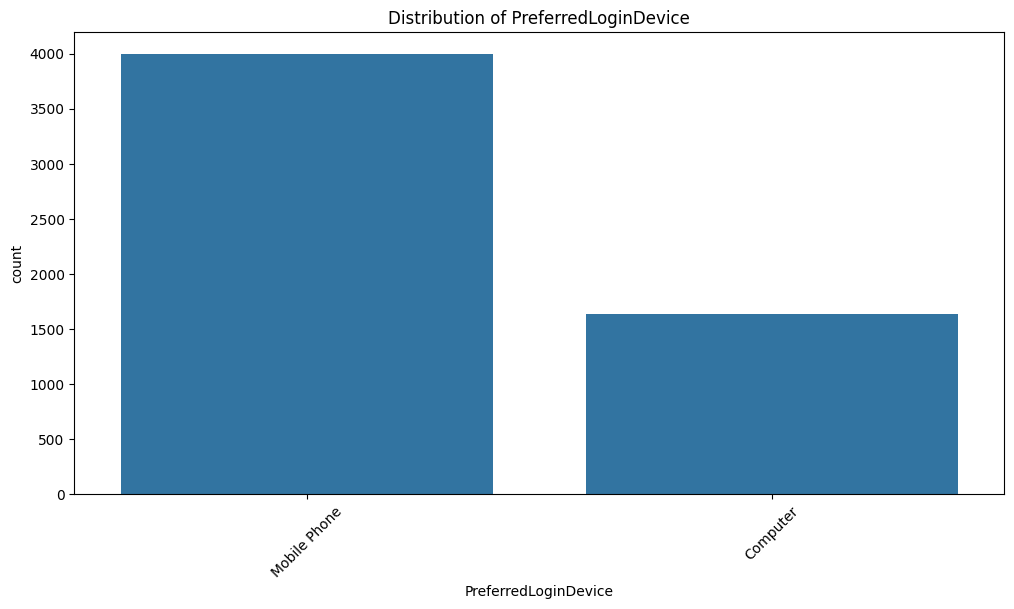

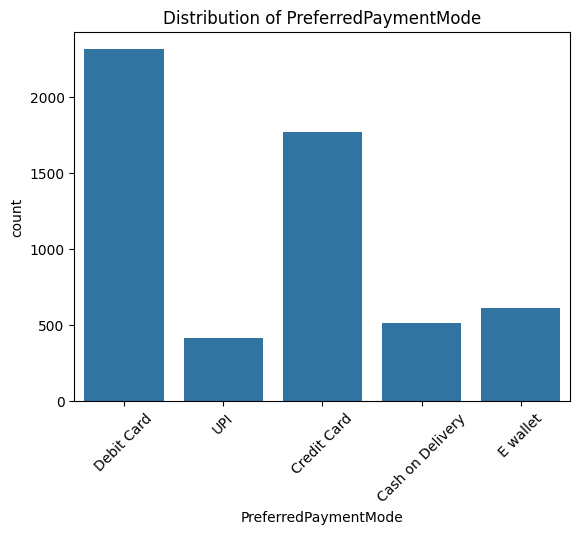

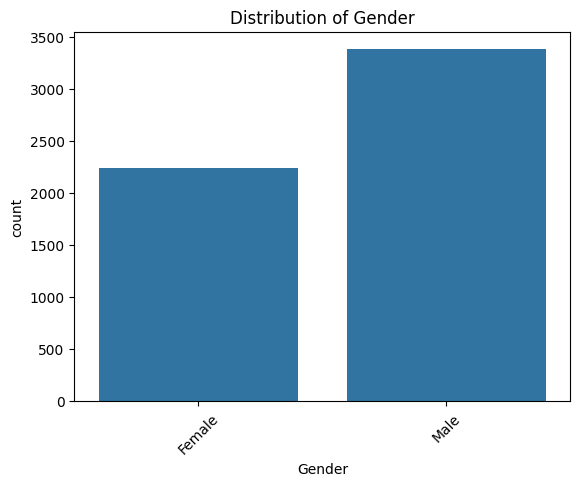

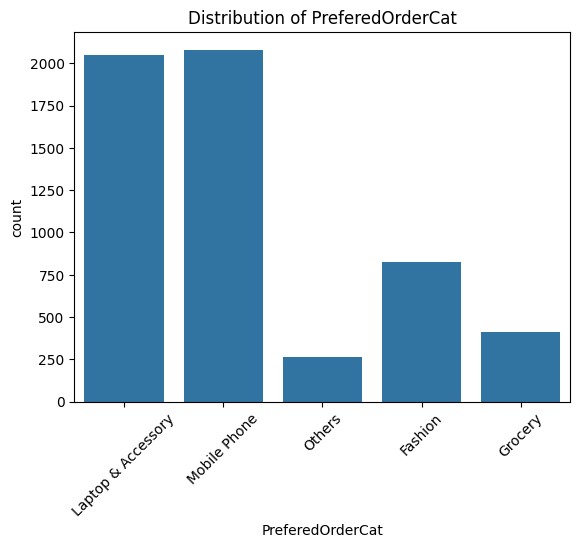

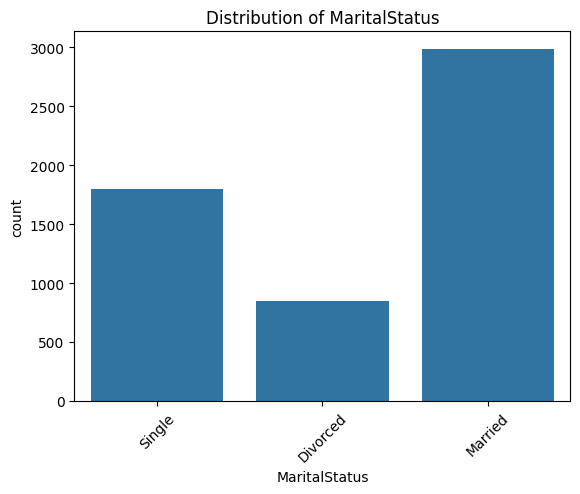

In [11]:
plt.figure(figsize=(12, 6))
for col in cat_cols:
    sns.countplot(x=df[col])
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()


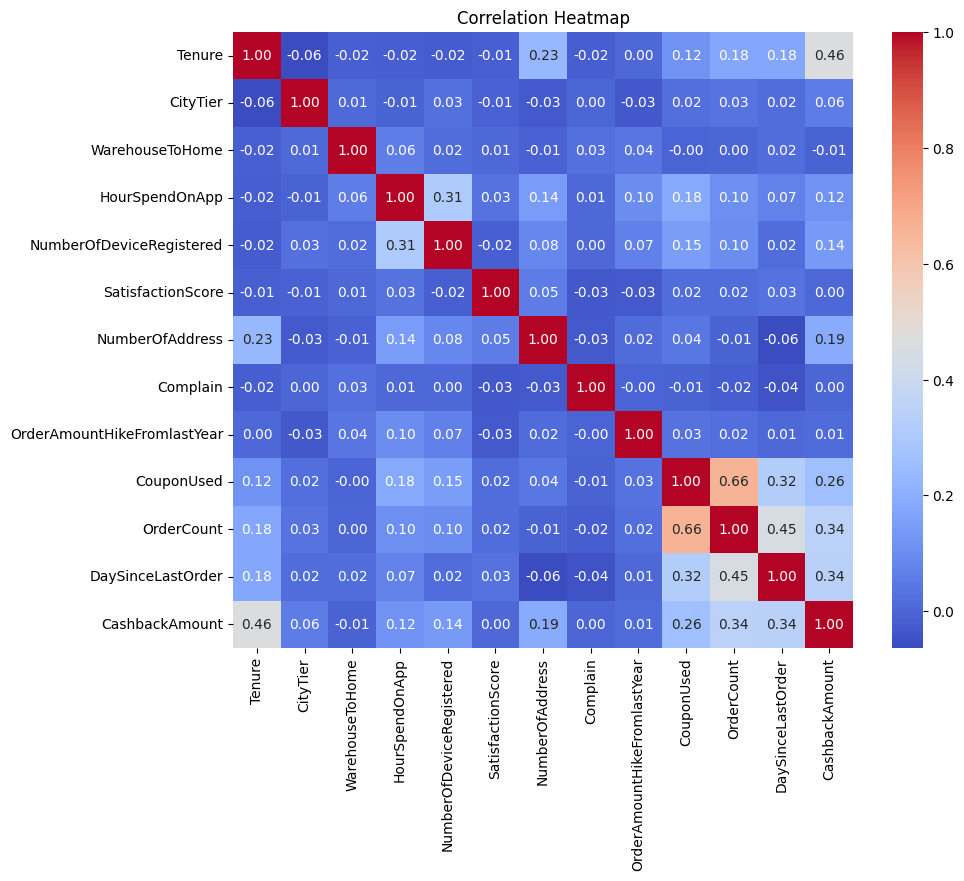

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [13]:
# ==== Encode categorical features using LabelEncoder ====
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [14]:
# ==== Separate Features and Target ====
X = df.drop(columns=["Churn"])
y = df["Churn"]

In [33]:
print(f"Missing values in X before SMOTE: {X.isna().sum().sum()}")

Missing values in X before SMOTE: 0


In [34]:
#      Handle Imbalanced Data
# ================================
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [17]:
#    Feature Selection using Random Forest
# ========================================= 
base_rf = RandomForestClassifier(random_state=42)
base_rf.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

In [18]:
# Use median importance as threshold
selector = SelectFromModel(base_rf, threshold="median", prefit=True)
X_selected_all = selector.transform(X_resampled)
selected_all_features = X.columns[selector.get_support()].tolist()

In [19]:
# === FIX: Do NOT drop any columns after feature selection ===
selected_features = selected_all_features
X_final = X_resampled[selected_features]

print(f"Selected features: {selected_features}")

Selected features: ['Tenure', 'CityTier', 'WarehouseToHome', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'DaySinceLastOrder', 'CashbackAmount']


In [20]:
#       Train/Test Split
# ================================
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_resampled, test_size=0.2, random_state=42
)

In [21]:
#     Random Forest Hyperparams (with stronger regularization)
# ================================
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [6, 8, 10],  # Lower max_depth to prevent deep trees
    "min_samples_split": [5, 10, 20],  # Increase min_samples_split
    "min_samples_leaf": [4, 8, 12],    # Increase min_samples_leaf
    "max_features": ["sqrt", "log2"],  # Limit number of features per split
    "class_weight": ["balanced"],
}

In [22]:
#    Hyperparameter Tuning (RSCV)
# ================================
rf = RandomForestClassifier(random_state=42, bootstrap=True)
random_search = RandomizedSearchCV(
    rf, param_grid, cv=5, scoring="roc_auc", n_iter=10, verbose=2, n_jobs=-1
)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'class_weight': ['balanced'],
                                        'max_depth': [6, 8, 10],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [4, 8, 12],
                                        'min_samples_split': [5, 10, 20],
                                        'n_estimators': [100, 200]},
                   scoring='roc_auc', verbose=2)

In [23]:
#     Train Best Random Forest
# ================================
best_rf = RandomForestClassifier(
    **random_search.best_params_,
    max_samples=0.8,
    random_state=42,
    bootstrap=True
)
best_rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, max_samples=0.8,
                       min_samples_leaf=8, min_samples_split=5,
                       random_state=42)

In [24]:
#        Model Evaluation
# ================================
train_score = best_rf.score(X_train, y_train)
test_score = best_rf.score(X_test, y_test)
print(f"Train Accuracy: {train_score:.4f}")
print(f"Test Accuracy: {test_score:.4f}")

Train Accuracy: 0.9449
Test Accuracy: 0.9194


In [25]:
# ---- Cross-validation ----
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)  # More robust CV
cv_scores = cross_val_score(
    best_rf,
    X_final[selected_features],
    y_resampled,
    cv=cv,
    scoring="accuracy"
)
print(f"CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

CV Accuracy: 0.9326 ± 0.0076


In [26]:
# ---- Additional Metrics for Imbalanced Data ----
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
report = classification_report(y_test, y_pred)
print(report)

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")


Confusion Matrix:
[[865  74]
 [ 77 857]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       939
           1       0.92      0.92      0.92       934

    accuracy                           0.92      1873
   macro avg       0.92      0.92      0.92      1873
weighted avg       0.92      0.92      0.92      1873

ROC-AUC Score: 0.9785


In [27]:
# ==== Ensure model_reports directory exists ====
os.makedirs("model_reports", exist_ok=True)


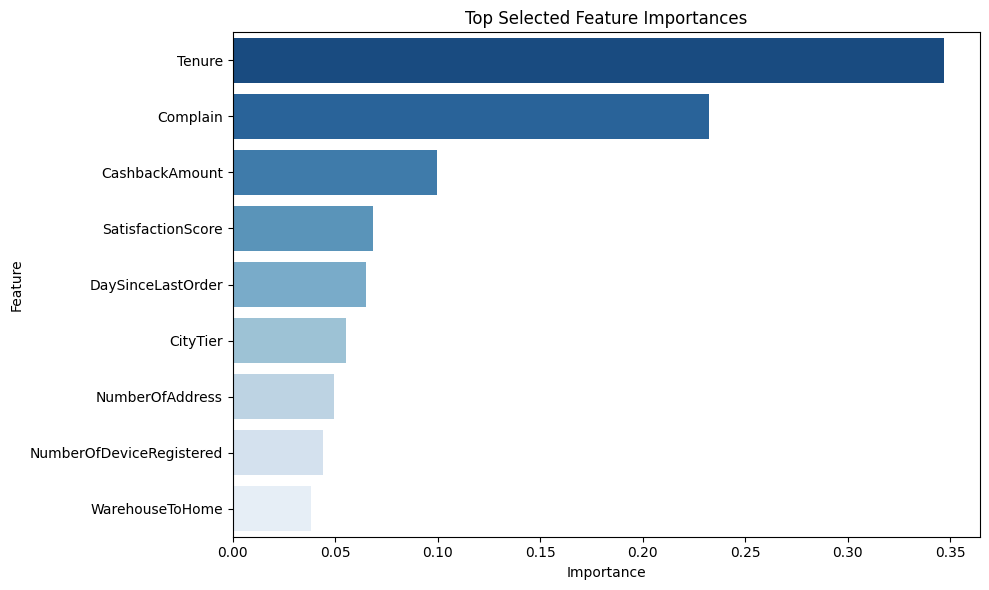

In [28]:
# ==== Plot and Save Feature Importances ====
importances = best_rf.feature_importances_
feat_imp = pd.Series(importances, index=selected_features).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp, y=feat_imp.index, palette="Blues_r")
plt.title("Top Selected Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

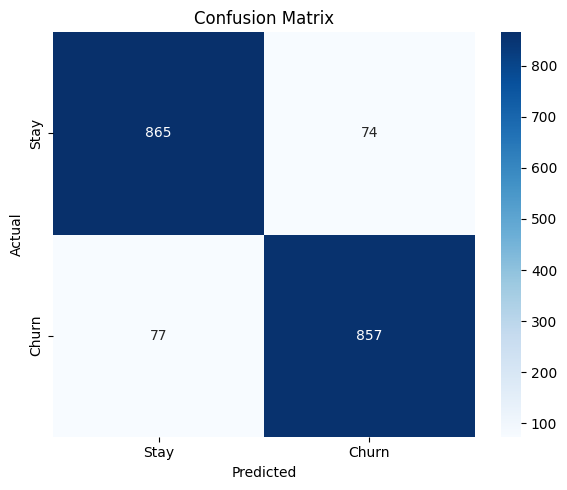

In [29]:
# ==== Plot and Save Confusion Matrix ====
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Stay", "Churn"], yticklabels=["Stay", "Churn"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

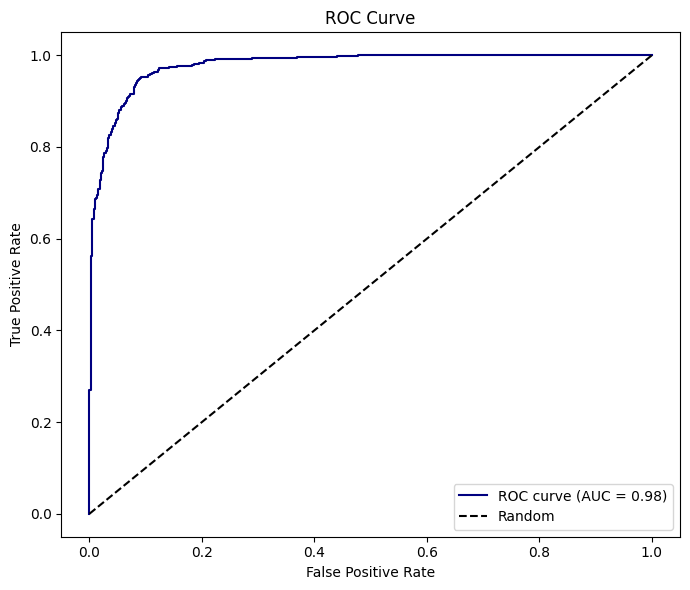

In [30]:
# ==== Plot and Save ROC Curve ====
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color="navy")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [31]:
#        Save Model Bundle
# ================================
model_bundle = {
    "model": best_rf,
    "features": selected_features,
    "label_encoders": label_encoders,
    "num_imputer": num_imputer,
}

joblib.dump(model_bundle, "churn_model_bundle.pkl")
print("Model saved as 'churn_model_bundle.pkl'")

Model saved as 'churn_model_bundle.pkl'
